Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:

groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)                                  
groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных                
active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.               
checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

1.3 Вопросы

Предлагаем вам ответить на следующие вопросы:

На какие метрики вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [91]:
import pandas as pd
import io
from urllib.parse import urlencode
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy import stats
import pandahouse as ph
import requests

Создал функцию,которая загружает и читает файлы с Yandex.Disk, используя API, и сохраняет содержимое каждого файла в отдельную переменную в формате DataFrame pandas. Каждый DataFrame содержит данные из соответствующего файла.

In [92]:
oauth_token = 'OAuth y0_AgAAAABohyeeAAwl8QAAAAELXbErAAAA8kTSr2RK5oqb9pm7HPVkfzTBOQ'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_keys = ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', 
               'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', 
               'https://disk.yandex.ru/d/pH1q-VqcxXjsVA',
               'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ']

for idx, public_key in enumerate(public_keys):
    final_url = base_url + urlencode({'public_key': public_key})
    headers = {'Authorization': f'OAuth {oauth_token}'}
    
    response = requests.get(final_url, headers=headers)
    
    if response.status_code == 200:
        download_url = json.loads(response.text)['href']
        
        # Скачиваем содержимое файла
        file_response = requests.get(download_url)
        
        # Создаем объект BytesIO из содержимого файла
        file_content = io.BytesIO(file_response.content)
        
        # Устанавливаем разделитель только для определенных файлов
        if idx < len(public_keys) - 1:
            sep = ';'
        else:
            sep = ','  # Установите разделитель для последнего файла
        
        # Считываем содержимое файла как CSV
        globals()[f'Data{idx+1}'] = pd.read_csv(file_content, sep=sep)


In [93]:
groups = Data1
active_studs = Data2
checks = Data3
groups_add = Data4

У нас есть четыре файла необходимо провести EDA с целью выявления закономерностей, трендов, аномалий и паттернов. 

Количество строк и столбцов

In [94]:
groups.shape

(74484, 2)

In [95]:
groups_add.shape

(92, 2)

In [96]:
active_studs.shape

(8341, 1)

In [97]:
checks.shape

(541, 2)

Информация о типах данных

In [98]:
groups.dtypes 

id      int64
grp    object
dtype: object

In [99]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [100]:
active_studs.dtypes

student_id    int64
dtype: object

In [101]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

Количество пропущенных значений

In [102]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [103]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [104]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [105]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Количество дублей

In [106]:
groups.duplicated().sum()

0

In [107]:
groups_add.duplicated().sum()

0

In [108]:
active_studs.duplicated().sum()

0

In [109]:
checks.duplicated().sum()

0

Количество уникальных значений по всем столбцам

In [110]:
groups.nunique().sum()

74486

In [111]:
groups_add.nunique().sum()

94

In [112]:
active_studs.nunique().sum()

8341

In [113]:
checks.nunique().sum()

580

Подсчет количества А и В элеменов по группам

In [114]:
groups.query("grp == 'A'").count()

id     14671
grp    14671
dtype: int64

In [115]:
groups.query("grp == 'B'").count()

id     59813
grp    59813
dtype: int64

In [116]:
groups_add.query("grp == 'A'").count()

id     22
grp    22
dtype: int64

In [117]:
groups_add.query("grp == 'B'").count()

id     70
grp    70
dtype: int64

Распределение по группам А и В в процентах

In [118]:
(groups.grp.value_counts() / groups.shape[0]).mul(100)

B    80.303152
A    19.696848
Name: grp, dtype: float64

In [119]:
(groups_add.grp.value_counts() / groups_add.shape[0]).mul(100)

B    76.086957
A    23.913043
Name: grp, dtype: float64

Изучение описательной статистики по столбцу 'rev'

In [120]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

В наших данных отсутствуют дубликаты пользователей и пропущенные значения, а также формат данных соответствует необходимому типу. Для того,чтобы в итоговый файл не попали не активные пользователи сделавшие покупку. Необходимо правильно оценить и соединить файлы. 


Датасет groups.csv содержит информацию о всех пользователях и их принадлежности к контрольной или экспериментальной группе. Датасет active_studs.csv содержит информацию о пользователях, которые зашли на платформу в день эксперимента. Файл groups_add.csv, хотя и маленький по размеру, также содержит информацию о пользователях, но не указывает за какой день и в каком эксперименте они участвуют. Наконец, датасет checks.csv содержит информацию об оплатах, совершенных в день эксперимента.
Для дальнейшего анализа необходимо объединить данные из этих четых датасетов, чтобы идентифицировать пользователей, участвующих в эксперименте, определить их принадлежность к группе А или В, а также выяснить, совершали ли они оплату в день эксперимента.
Объединить датасеты можно по колонке являющейся уникальным признаком объекта и называющейся по-разному в датасетах ('student_id','id').

In [121]:
# Переименовываю колонку с уникальными признаками во всех датасетах в unique_id
groups.rename(columns={'id': 'unique_id'}, inplace=True)
active_studs.rename(columns={'student_id': 'unique_id'}, inplace=True)
checks.rename(columns={'student_id': 'unique_id'}, inplace=True)
groups_add.rename(columns={'id': 'unique_id'}, inplace=True)

Создаем из имеющихся файлов два новых датафрейма:

merge_2 - поможет нам оценить CR - соотношение между количеством пользователей и тех кто совершившил целевое действие.

merge_3 - активные пользователи совершившие покупку в день эксперимента. Позволит нам оценить ARPPU. 

Под проверкой на баги я понимаю следующее: не активных пользователей надо выбросить. Пользователь должен быть активным и совершить покупку в процессе эксперимента. Те кто не был активным, но оплата произошла - предположительно автоматическая плата в месяц или баг. Так же в датафрейме не должно быть дублей, пропусков. 

In [122]:
# Успешно переименовал
groups.columns

Index(['unique_id', 'grp'], dtype='object')

In [123]:
active_studs.columns

Index(['unique_id'], dtype='object')

In [124]:
checks.columns

Index(['unique_id', 'rev'], dtype='object')

In [125]:
groups_add.columns

Index(['unique_id', 'grp'], dtype='object')

In [126]:
merge_1 = active_studs.merge(checks, how='left', on='unique_id')

In [127]:
merge_1.shape

(8341, 2)

In [128]:
merge_1.isna().sum()

unique_id       0
rev          7949
dtype: int64

In [129]:
merge_1[:3]

,unique_id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN


In [130]:
# Заменил пропуски нулями.
merge_1 = merge_1.fillna(0)

In [131]:
merge_1.isna().sum()

unique_id    0
rev          0
dtype: int64

In [132]:
merge_concat = pd.concat([groups, groups_add], ignore_index=True)

In [133]:
merge_2 = merge_1.merge(merge_concat, how='inner', on='unique_id')

In [134]:
merge_2

,unique_id,rev,grp
0,581585,0.0,A
1,5723133,0.0,A
2,3276743,0.0,B
3,4238589,0.0,A
4,4475369,0.0,B
...,...,...,...
8336,1794344,0.0,B
8337,296883,0.0,B
8338,3598448,0.0,B
8339,3610547,290.0,B


Необходимо создать дополнительную колонку,где 1 - совершил покупку, 0 - не совершил покупку. 

In [135]:
merge_2['purchase'] = np.where(merge_2['rev'] != 0, 1, 0)

In [136]:
merge_2

,unique_id,rev,grp,purchase
0,581585,0.0,A,0
1,5723133,0.0,A,0
2,3276743,0.0,B,0
3,4238589,0.0,A,0
4,4475369,0.0,B,0
...,...,...,...,...
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1


In [137]:
merge_2.isna().sum()

unique_id    0
rev          0
grp          0
purchase     0
dtype: int64

In [138]:
merge_2['unique_id'].duplicated().sum()

0

In [139]:
(merge_2.grp.value_counts() / merge_2.shape[0]).mul(100)

B    81.560964
A    18.439036
Name: grp, dtype: float64

In [140]:
merge_2.query("grp == 'A'").count()

unique_id    1538
rev          1538
grp          1538
purchase     1538
dtype: int64

In [141]:
merge_2.query("grp == 'B'").count()

unique_id    6803
rev          6803
grp          6803
purchase     6803
dtype: int64

In [142]:
merge_3 = active_studs.merge(merge_concat.merge(checks, on='unique_id'), on='unique_id')

In [143]:
merge_3 = merge_3.round()

In [144]:
merge_3 

,unique_id,grp,rev
0,1184303,A,1530.0
1,3354191,B,1900.0
2,3278734,B,1900.0
3,720651,A,1980.0
4,1232221,B,1900.0
...,...,...,...
387,3890326,B,199.0
388,1390994,A,398.0
389,1516339,A,290.0
390,3910596,B,597.0


In [145]:
merge_3.shape

(392, 3)

In [146]:
merge_3.isna().sum()

unique_id    0
grp          0
rev          0
dtype: int64

In [147]:
merge_3['unique_id'].duplicated().sum()

0

In [148]:
(merge_3.grp.value_counts() / merge_3.shape[0]).mul(100)

B    80.102041
A    19.897959
Name: grp, dtype: float64

In [149]:
merge_3.query("grp == 'A'").count()

unique_id    78
grp          78
rev          78
dtype: int64

In [150]:
merge_3.query("grp == 'B'").count()

unique_id    314
grp          314
rev          314
dtype: int64

При визуализации боксплота было обнаружено наличие выбросов как в группе А, так и в группе В. Это может существенно ограничить наши возможности при выборе метода для оценки статистических показателей.

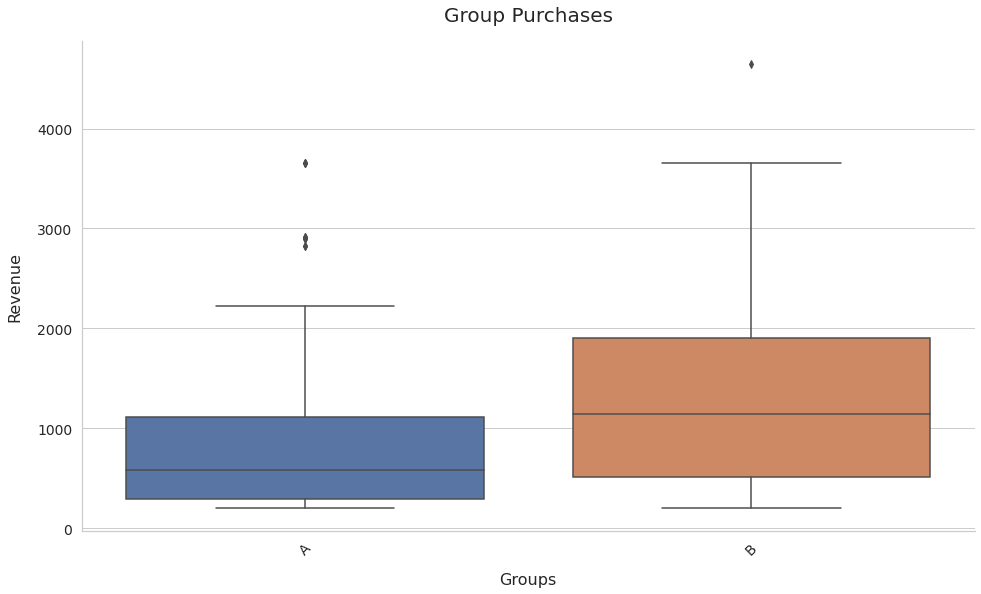

In [151]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 9))
sns.boxplot(x='grp', y='rev', data=merge_2.query('rev!=0'))
plt.xlabel('Groups', fontsize=16, labelpad=15)
plt.ylabel('Revenue', fontsize=16, labelpad=15)
plt.title("Group Purchases", fontsize=20, pad=20)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
plt.show()

Из графиков видно, что распределения данных значительно отличаются от нормальных. Это подчеркивает необходимость особого внимания при анализе и использовании альтернативных методов и подходов для получения достоверных результатов.

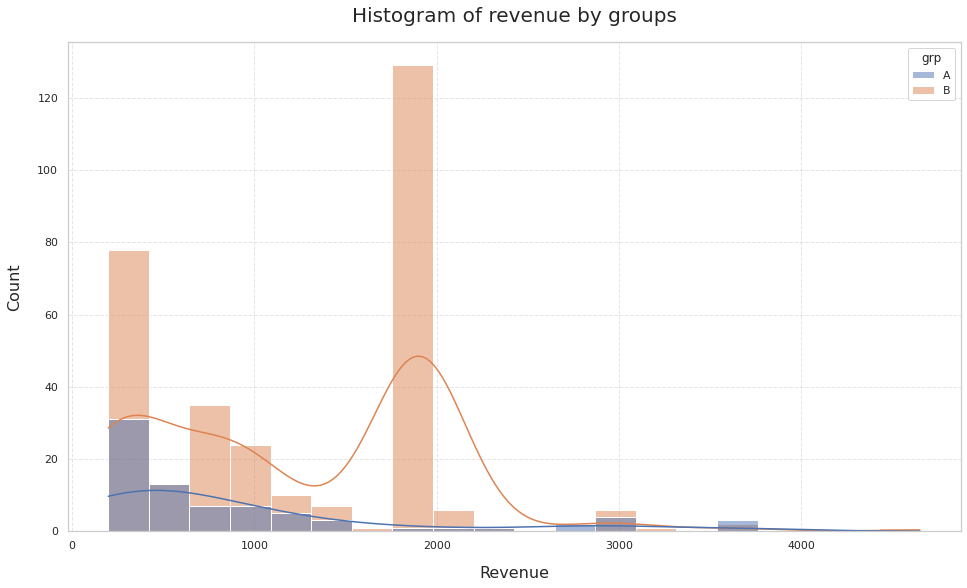

In [152]:
# построение распределения данных групп о покупках среди покупающих пользователей
sns.set(style="whitegrid")
plt.figure(figsize=(16, 9))
sns.histplot(x=merge_3.rev, hue=merge_3.grp, data=checks, bins=20, kde=True)
plt.xlabel('Revenue', fontsize=16, labelpad=15)
plt.ylabel('Count', fontsize=16, labelpad=15)
plt.title("Histogram of revenue by groups", fontsize=20, pad=20)
plt.grid(True, which='major', axis='both', linestyle='--', alpha=0.5)
plt.show()

Было принято решение использовать метод бутстрэпа. Этот метод особенно ценен в случаях, когда имеются ограничения по данным или данные не соответствуют стандартным предположениям о распределении.

In [153]:
def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок
        statistic=np.median,  # интересующая нас статистика
        bootstrap_conf_level=0.99):  # уровень значимости
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        boot_data.append(statistic(samples_2 - samples_1))  # применяем статистику
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    #  Визуализация
    plt.figure(figsize=(20, 10))
    #  plt.hist()
    sns.histplot(x=pd_boot_data[0], bins=50)
    #  plt.style.use('ggplot')    
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

Первая метрика:"Average Revenue Per Paying User" (ARPPU) - это показатель, который часто используется для измерения среднего дохода с каждого платящего пользователя. При наличии соответствующих данных вычислить этот показатель довольно удобно.

100%|██████████| 10000/10000 [00:07<00:00, 1427.98it/s]


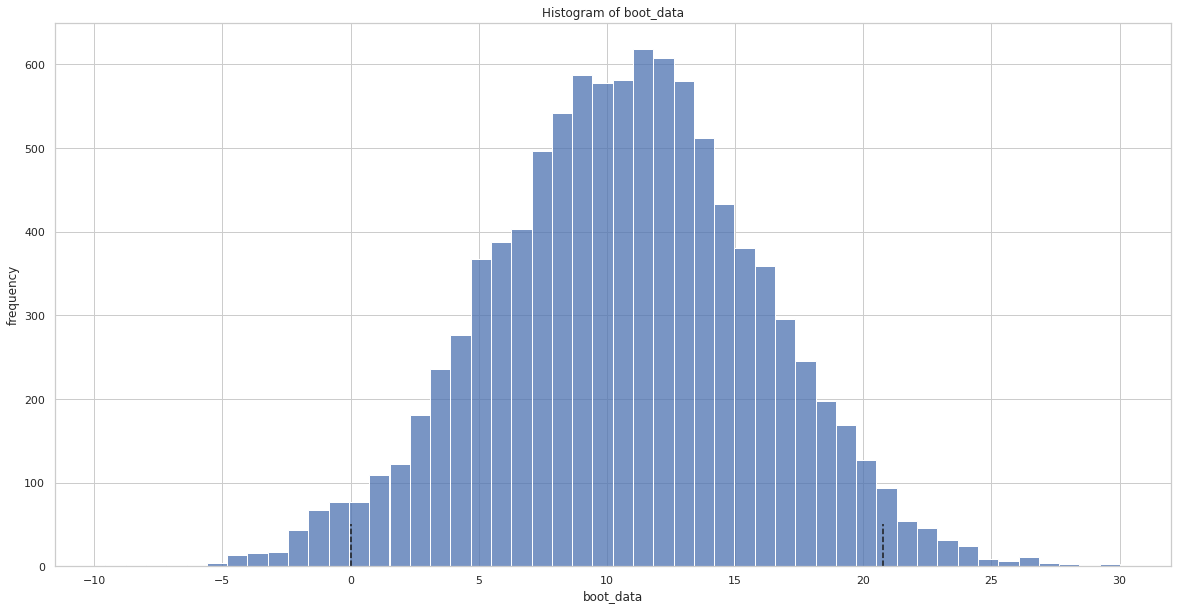

In [154]:
boot_data = get_bootstrap(
    merge_2[merge_2.grp == "A"].rev,  # контрольная группа
    merge_2[merge_2.grp == "B"].rev,  # целевая группа
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95)  # уровень значимости

In [155]:
print(boot_data['p_value'])

0.040927099632541306


100%|██████████| 10000/10000 [00:03<00:00, 3035.37it/s]


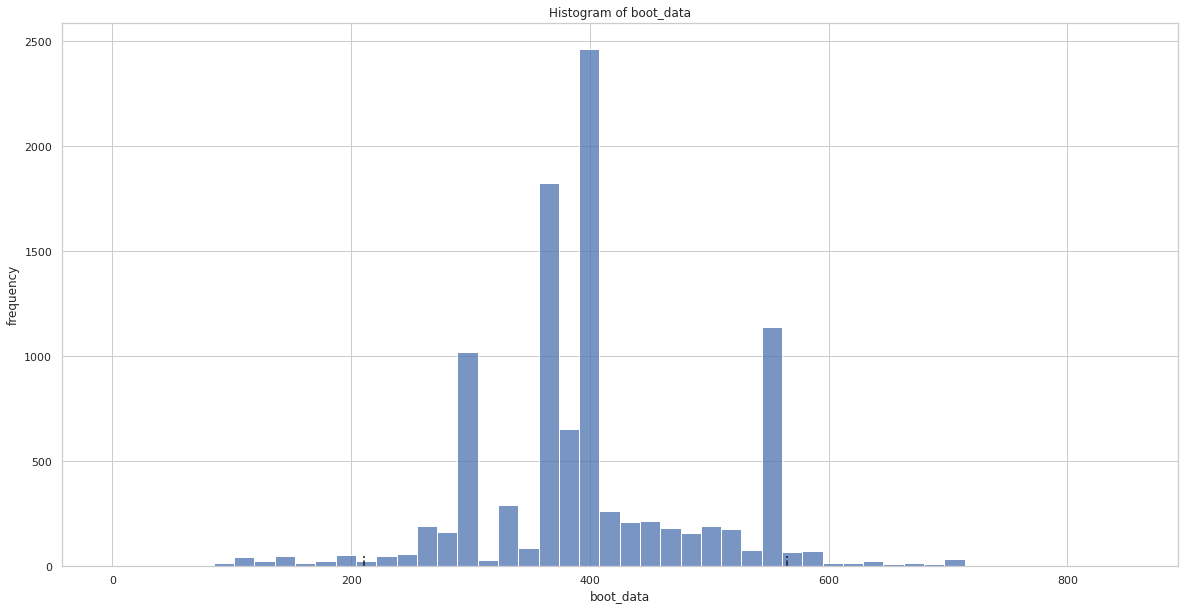

In [156]:
boot_data = get_bootstrap(
    merge_3[merge_3.grp == "A"].rev,  # контрольная группа
    merge_3[merge_3.grp == "B"].rev,  # целевая группа
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика
    bootstrap_conf_level=0.95)  # уровень значимости

In [157]:
# p-значение
print(boot_data['p_value'])

2.1281589344539592e-05


In [158]:
# Доверительный интервал
print(boot_data['ci'])

              0
0.025  210.4750
0.975  565.1125


In [159]:
group_A = merge_3[merge_3['grp'] == 'A']
group_B = merge_3[merge_3['grp'] == 'B']

Расчет Average Revenue Per Paying User для группы A и B.

In [160]:
ARPPU_A = group_A['rev'].sum() / group_A['unique_id'].nunique()

In [161]:
ARPPU_B = group_B['rev'].sum() / group_B['unique_id'].nunique()

Расчет разницы между ARPPU групп A и B в процентах.

In [162]:
difference_percent = round(((ARPPU_B - ARPPU_A) / ARPPU_A * 100), 1)

In [163]:
print('ARPPU группы A:', ARPPU_A)
print('ARPPU группы B:', ARPPU_B)
print(f'Целевая группа B больше контрольной группы A на: {difference_percent}%')

ARPPU группы A: 933.5897435897435
ARPPU группы B: 1257.8789808917197
Целевая группа B больше контрольной группы A на: 34.7%


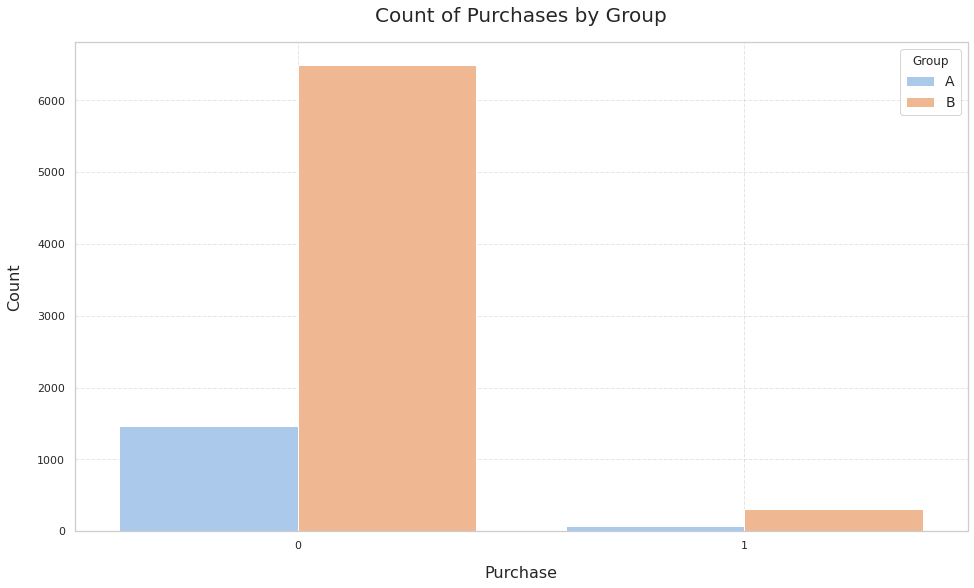

In [164]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 9))
sns.countplot(x="purchase", hue="grp", data=merge_2, palette="pastel")  
plt.xlabel("Purchase", fontsize=16, labelpad=15)
plt.ylabel("Count", fontsize=16, labelpad=15)
plt.title("Count of Purchases by Group", fontsize=20, pad=20)
plt.legend(title="Group", loc="upper right", fontsize=14)
plt.grid(True, which='major', axis='both', linestyle='--', alpha=0.5)
plt.show()

In [165]:
def calculate_conversion(row):
  
  return row[1] / row.sum()  

conversion = pd.crosstab(merge_2.grp, merge_2.purchase)
conversion['conversion'] = conversion.apply(calculate_conversion, axis=1)

print(conversion) 

purchase     0    1  conversion
grp                            
A         1460   78    0.050715
B         6489  314    0.046156


In [166]:
stat, p, dof, expected = stats.chi2_contingency(conversion)
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
print('p-value =', round(stat, 2)) 

p-value = 0.66


Сформулируем нулевую и альтернативную гипотезы:

H0: ARPPU, CR в двух группах одинаковые.

H1: ARPPU, CR в двух группах различаются.

Бутстрап-тест показал p-value > 0,05 для ARPPU, что не позволяет нам отвергнуть нулевую гипотезу о равенстве ARPPU в двух группах.  Доверительный интервал для ARPPU не проходит через 0, что указывает на статистически значимое различие между группами.  ARPPU группы B отличается от группы A на 34.7%. Несмотря на то, что тест не позволяет отвергнуть H0,  доверительный интервал  указывает на различие. Это значит, что наблюдаемое различие в ARPPU, вероятно, неслучайно. 

Критерий хи-квадрат не выявил статистически значимых различий в CR между группами.  Бутстрап-тест также показал p-value > 0,05, подтверждая отсутствие статистически значимых различий.  Мы не можем отвергнуть нулевую гипотезу о равенстве CR в двух группах.  Значительный эффект на показатели СR не подтвердился.  При этом увеличился показатель ARPPU.

Внедрение новой механики оплаты необходимо, поскольку увеличение ARPPU свидетельствует о потенциальной эффективности.  Однако следует внимательно отслеживать влияние на CR и  провести дополнительный анализ для оптимизации и минимизации рисков.

Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas:
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [167]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [168]:
q_1 = '''
    SELECT
      COUNT(DISTINCT st_id)
    FROM
      (
    SELECT
      st_id,
      toDayOfMonth(timest) AS day,
      toHour(timest) AS hour,
      SUM(correct) AS SUM_correct
    FROM peas
    WHERE toStartOfMonth(timest) = '2020-03-01'
    GROUP BY
      st_id,
      day,
      hour
    HAVING SUM_correct >= 20
      )
    '''

In [169]:
numb_stud_dil = ph.read_clickhouse(query=q_1, connection=connection_default)

In [170]:
print(f"Количество очень усердных учеников:", numb_stud_dil)

Количество очень усердных учеников:    uniqExact(st_id)
0                 0


2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [171]:
q_2 = '''
   SELECT
    test_grp,
    sum(total_revenue) / uniqExact(st_id) as ARPU,
    sumIf(total_revenue, active_stud=1) / uniqExactIf(st_id, active_stud=1) as ARPAU,
    uniqExactIf(st_id, total_revenue > 0) / uniqExact(st_id) as CR,
    uniqExactIf(st_id, active_stud=1 and total_revenue>0) / uniqExactIf(st_id, active_stud=1) as CR_active,
    uniqExactIf(st_id, math_active_stud=1 and math_revenue>0) / uniqExactIf(st_id, math_active_stud=1) as CR_math_active
   FROM
    (
    SELECT 
        l.test_grp as test_grp,
        l.st_id as st_id,
        r.active_stud as active_stud,
        r.math_active_stud as math_active_stud,
        r.total_revenue as total_revenue,
        r.math_revenue as math_revenue
    FROM
        (
        SELECT
            test_grp,
            st_id
        FROM studs
        ) l
    LEFT JOIN
        (
        SELECT
            l.st_id as st_id,
            l.active_stud as active_stud,
            l.math_active_stud as math_active_stud,
            r.total_revenue as total_revenue,
            r.math_revenue as math_revenue
        FROM
            (
            SELECT
                st_id,
                if(sum(correct) > 10, 1, 0) as active_stud,
                if(sumIf(correct, subject='Math') >= 2, 1, 0) as math_active_stud
            FROM peas
            GROUP BY
                st_id
            ) l
        LEFT JOIN
            (
            SELECT
                st_id,
                sum(money) as total_revenue,
                sumIf(money, subject='Math') as math_revenue
            FROM final_project_check
            GROUP BY st_id
            ) r
        ON l.st_id = r.st_id
        ) r
    ON l.st_id = r.st_id
    )
GROUP BY
    test_grp;

    '''

In [172]:
result_metrics = ph.read_clickhouse(query=q_2, connection=connection_default)

In [173]:
print(result_metrics)

  test_grp          ARPU         ARPAU        CR  CR_active  CR_math_active
0  control   4540.983607  10393.700787  0.049180   0.110236        0.061224
1    pilot  11067.796610  29739.583333  0.101695   0.260417        0.095238


Задание 3. Python

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [174]:
def groups_add(groups, active_studs, checks, filename='Проект_2_group_add.csv'):
    """
    Функция автоматически подгружает информацию из дополнительного файла groups_add.csv 
    и пересчитывает метрики.
    
    Args:
        groups (pd.DataFrame): DataFrame с информацией о группах пользователей.
        active_studs (pd.DataFrame): DataFrame с информацией об активных пользователях.
        checks (pd.DataFrame): DataFrame с информацией о чеках.
        filename (str, optional): Имя файла с дополнительной информацией о группах. Defaults to 'Проект_2_group_add.csv'.

    Returns:
        dict: Словарь с обновленными метриками.
    """
    # Загружаем дополнительный файл 
    groups_add = pd.read_csv(filename, sep=',')
    
    # Переименовываем столбцы в groups_add, чтобы они соответствовали остальным DataFrame
    groups_add.rename(columns={groups_add.columns[0]: 'unique_id', groups_add.columns[1]: 'grp'}, inplace=True)

    # Объединяем DataFrame с группами
    full_groups = groups.append(groups_add)

    # Добавляем столбец "active" в active_studs 
    active_studs['active'] = 1

    # Объединяем все DataFrame
    full_data = pd.merge(full_groups, active_studs, on='unique_id', how='left')
    full_data = pd.merge(full_data, checks, on='unique_id', how='left')
    full_data = full_data.fillna(0)

    # Считаем метрики
    conv_table = pd.crosstab(full_data.grp, full_data.purchase)

    arppu = pd.DataFrame({'grp': ['A', 'B'],
                          'ARPPU': [
                              full_data.query('grp == "A"').rev.sum() / full_data.query('grp == "A"').unique_id.nunique(),
                              full_data.query('grp == "B"').rev.sum() / full_data.query('grp == "B"').unique_id.nunique()
                          ]})
    avg_check = pd.DataFrame({'grp': ['A', 'B'],
                          'avg_check': [
                              round(full_data.query('grp == "A" & rev > 0').rev.mean(), 1),
                              round(full_data.query('grp == "B" & rev > 0').rev.mean(), 1)
                          ]})
    conversion = pd.DataFrame(conv_table[1] / conv_table[0]) \
        .reset_index() \
        .rename(columns={0: 'cr'})

    return {'arppu': arppu,
            'avg_check': avg_check,
            'conversion': conversion}


In [175]:
def plot_metrics(metrics):
    """
    Строит графики по метрикам.
    
    Args:
        metrics (dict): Словарь с метриками.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # ARPPU
    axes[0].bar(metrics['arppu'].grp, metrics['arppu'].ARPPU, color=['blue', 'orange'])
    axes[0].set_title('ARPPU')
    axes[0].set_ylabel('ARPPU')

    # Средний чек
    axes[1].bar(metrics['avg_check'].grp, metrics['avg_check'].avg_check, color=['blue', 'orange'])
    axes[1].set_title('Средний чек')
    axes[1].set_ylabel('Средний чек')

    # Конверсия
    axes[2].bar(metrics['conversion'].grp, metrics['conversion'].cr, color=['blue', 'orange'])
    axes[2].set_title('Конверсия')
    axes[2].set_ylabel('CR')

    plt.tight_layout()
    plt.show()

In [176]:
groups = pd.DataFrame({'unique_id': [1, 2, 3, 4, 5], 'grp': ['A', 'A', 'A', 'B', 'B']})

In [177]:
active_studs = pd.DataFrame({'unique_id': [1, 2, 3, 4, 5], 'student_id': [1, 2, 3, 4, 5]})

In [178]:
checks = pd.DataFrame({'unique_id': [1, 2, 4, 5], 'purchase': [1, 0, 1, 1], 'rev': [100, 0, 200, 150]})

In [179]:
metrics = groups_add(groups, active_studs, checks)

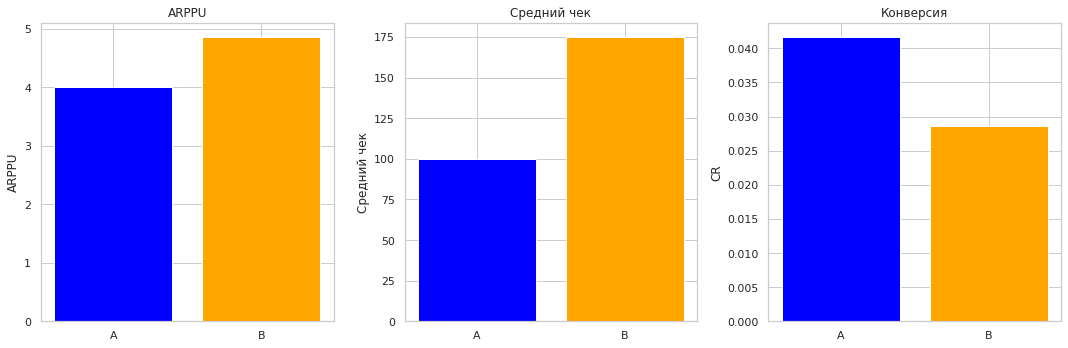

In [180]:
plot_metrics(metrics)